In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import cv2
from tqdm import tqdm
from tqdm.std import trange
from torch.utils.data import dataloader
from pixelshuffle1d import PixelShuffle1D, PixelUnshuffle1D

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate data

$-\bigtriangledown\cdot  \left ( exp(\kappa ) \bigtriangledown u\left ( \textbf{x} \right )\right )=f\left ( \textbf{x} \right )$ 

$x\subseteq \left [ 0,1 \right ], y\subseteq \left [ 0,1 \right ]$ 

$f(x) = -(8π^2) * sin(2aπ(x+c)) * sin(2bπ(y+d))$

$a,b \in [0,2]; c,d \in [-2\pi,2\pi]$

$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$

### Finite-difference

In [3]:
def generate_data(N,type):
    h=1/N
    x=np.arange(0,1.0001,h)
    y=np.arange(0,1.0001,h)
    
    w=np.zeros((N+1,N+1))

    for j in range (0,N):
        w[0,j]=0 #Lower Boundary
        w[N,j]=0 #Upper Boundary
    
    N2=(N-1)*(N-1)
    A=np.zeros((N2,N2))
    ## Diagonal            
    for i in range (0,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j]=-4

    # LOWER DIAGONAL        
    for i in range (1,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j-1]=1   
    # UPPPER DIAGONAL        
    for i in range (0,N-2):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j+1]=1   

    # LOWER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (1,N-1):           
            A[i+(N-1)*j,i+(N-1)*(j-1)]=1        
        
        
    # UPPER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (0,N-2):           
            A[i+(N-1)*j,i+(N-1)*(j+1)]=1
    Ainv=np.linalg.inv(A) 
    
    r=np.zeros(N2)
    
    a = np.random.uniform(0,2)
    b = np.random.uniform(0,2)
    c = np.random.uniform(-2*np.pi,2*np.pi)
    d = np.random.uniform(-2*np.pi,2*np.pi)

    # vector r      
    for i in range (0,N-1):
        for j in range (0,N-1):
            if type == "mean":      
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*np.pi*x[i+1]) * np.sin(2*np.pi*y[j+1])*h**2
            elif type == "test":
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*1.2*np.pi*(x[i+1]-np.pi)) * np.sin(2*np.pi*(y[j+1]+np.pi))*h**2
            else:
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*np.pi*(x[i+1]+c)) * np.sin(2*np.pi*(y[j+1]+d))*h**2
    
    C=np.dot(Ainv,r)
    w[1:N,1:N]=C.reshape((N-1,N-1))
    
    return w, r, A, x, y
    

In [4]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"mean")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"mean")

### Plot

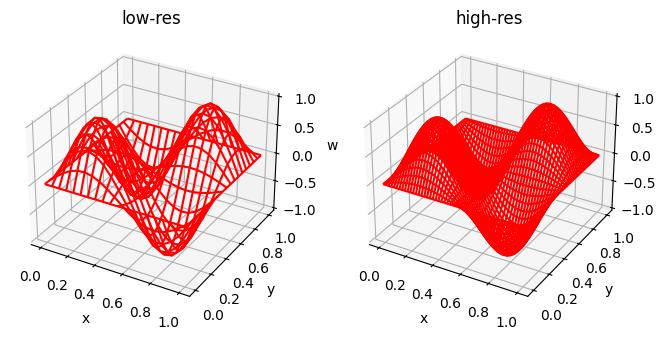

In [5]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, w_low,color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

Text(0, 0.5, 'y')

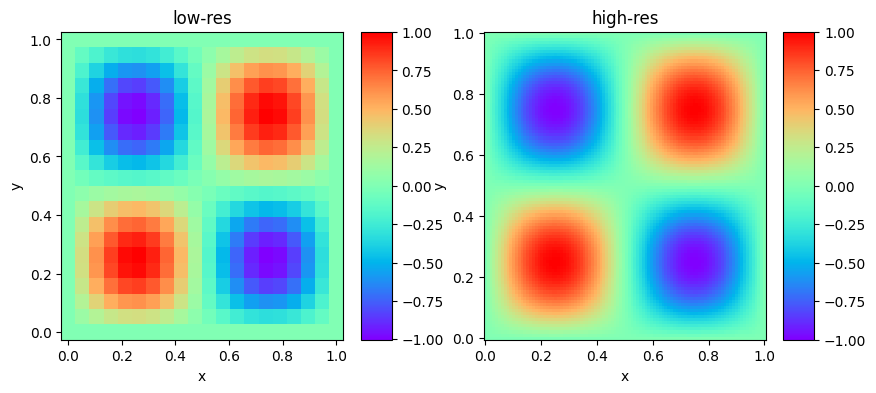

In [6]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low,y_low, w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')
plt.title('low-res')
plt.subplot(1,2,2)
plt.pcolormesh(x_high,y_high,w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('high-res')
plt.xlabel('x')
plt.ylabel('y')

## Calculate prior of $u^l$

In [7]:
def gaussian_kernal(x1,x2,y1,y2,l,sigma,N):
    m = (N-1)*(N-1)
    n = (N-1)*(N-1)
    dist_matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = (y1[(i+1)%(N-1)]-y2[(i+1)%(N-1)])**2 + (x1[i//(N-1)+1]-x2[i//(N-1)+1])**2
            # dist_matrix[i][j] = (x1[(i+1)%(N-1)]-x2[(i+1)%(N-1)])**2 + (y1[i//(N-1)+1]-y2[i//(N-1)+1])**2
            #dist_matrix[i][j] = np.sum([x1[(i+1)%(N-1)],y1[i//(N-1)+1]]-[x2[(i+1)%(N-1)],y2[i//(N-1)+1]])**2
    
    return sigma ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

# Define mean and covariance matrix of f
m = r_low
G = gaussian_kernal(x_low,x_low,y_low,y_low,0.1,0.3,N_low)

In [23]:
# Mean and covariance matrix of u
mean_u = np.matmul(np.linalg.inv(A_low),m)
covariance_u = np.matmul(np.linalg.solve(A_low,G),np.linalg.inv(A_low).T)

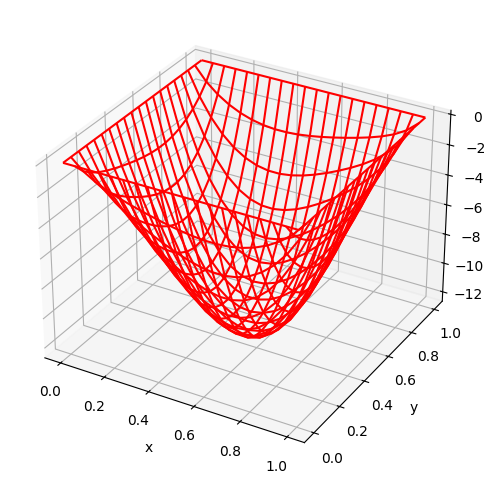

In [24]:
# Take one sample from the prior
C = np.random.multivariate_normal(mean_u.ravel(),covariance_u)
w_sample = np.copy(w_low)
w_sample[1:N_low,1:N_low]=C.reshape((N_low-1,N_low-1))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax.plot_wireframe(X, Y, w_sample,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()

Text(0, 0.5, 'y')

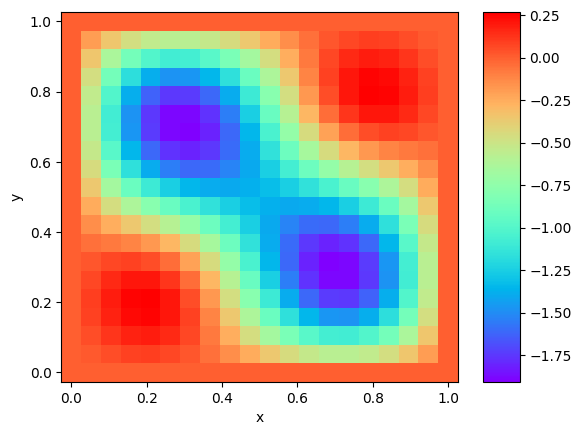

In [10]:
plt.pcolormesh(x_low,y_low, w_sample, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')

## Upscaling network

In [21]:
class UpScale(torch.nn.Module):
    def __init__(self):
        super(UpScale, self).__init__()
        self.layer1 = torch.nn.Conv2d(in_channels=1, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv2d(in_channels=25, out_channels=50, kernel_size=3, stride=1,padding=1)
        #self.layer3 = torch.nn.Conv1d(in_channels=6, out_channels=6, kernel_size=3, stride=1,padding=1)
        self.layer4 = torch.nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.PReLU = torch.nn.PReLU()
        self.shuffle = torch.nn.PixelShuffle(5)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.PReLU(x)
        #x = self.layer3(x)+x1
        x = self.layer4(x)
        x = self.shuffle(x)

        # log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return x

model = UpScale()
input = torch.tensor(w_low.reshape(1, w_low.shape[0],-1))
input = input.to(torch.float32)
print(model(input).shape)

torch.Size([1, 100, 100])


## Dataloader

In [ ]:
with h5py.File('high_res_GP.h5', 'r') as hf:
    data = hf['high_res_GP'][:]

In [23]:
trainset = torch.utils.data.DataLoader(dataset=data,batch_size=1,shuffle=False)

In [24]:
len(trainset)

64

## Training

In [ ]:
# Initialise network
# 定义模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

# Initialise parameters
sigma = 1
# Sigma = torch.eye((N_high+1)**2)
N_samples = 100
batch_size = 1
epoch_number = 200
minimum_loss = 10000000

# Sample from p(u^l)
'''sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)'''

for epoch in tqdm(range(epoch_number)):
    for j in range(64):
        # Calculate log likelihood based on all low-resolution samples
        log_likelihood = []
        # Log the maximum log likelihood and its index
        max_index = 0
        log_lik_max = -1000000
        w_high = data[j]
        w_high = torch.tensor(w_high.reshape(1,w_high.shape[0],-1))
        w_high = w_high.to(torch.float32)
        w_high = w_high.reshape(1,-1)
        for i in range(N_samples):
            input = np.zeros((N_low+1,N_low+1))
            input[1:N_low,1:N_low] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(N_low-1,N_low-1)
            input = torch.tensor(input.reshape(1,input.shape[0],-1))
            input = input.to(torch.float32)
            output = model(input)
            output = output.reshape(1,-1)
            log_lik = - 0.5 /sigma**2 * torch.sum((output-w_high)**2)
            # log_lik = - 0.5 * torch.matmul(torch.matmul(output-w_high,10000*Sigma),torch.transpose(output-w_high,0,1))
            log_likelihood.append(log_lik)
            if log_lik > log_lik_max:
                max_index = i
                log_lik_max = log_lik
        
        # Calculate log marginal likelihood
        max_likelihood = log_likelihood[max_index]
        value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
        for i in range(1,N_samples):
            value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
        log_marginal = max_likelihood + torch.log(value)
        
        loss = -log_marginal
        
        optim.zero_grad()
        '''if loss < minimum_loss:
            torch.save(model.state_dict(), 'best_2D_model_GP2.pth')
            minimum_loss = loss'''
        loss.backward()
        optim.step()
        torch.save(model.state_dict(), 'best_2D_model_GP2.pth')
        '''if (epoch+1)%100 == 0:
            print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))'''
        print("Epoch: {}".format(epoch), "Sample: {}".format(j), "Loss: {}".format(loss.item()))


In [15]:
max_index = 0
log_lik_max = -1000000000
w_high = torch.tensor(data.reshape(64,1,100,100))
w_high = w_high.to(torch.float32)
input = np.zeros((64,N_low+1,N_low+1))
input[0,1:N_low,1:N_low] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(N_low-1,N_low-1)
for i in range(1,64):
    input[i] = input[0]
input = torch.tensor(input.reshape(-1,1,20,20))
input = input.to(torch.float32)
output = model(input)


In [16]:
w_high.shape

torch.Size([64, 1, 100, 100])

In [23]:
torch.sum(((output-w_high)**2)[0])

tensor(156225.5625, grad_fn=<SumBackward0>)

In [24]:
torch.mean(torch.sum((output-w_high)**2,(1,2,3)))

tensor(207013.6406, grad_fn=<MeanBackward0>)

In [ ]:
log_lik = - 0.5 /sigma**2 * torch.sum((output-w_high)**2)
log_likelihood.append(log_lik)
if log_lik > log_lik_max:
    max_index = i
    log_lik_max = log_lik

In [45]:
output.shape

torch.Size([16, 1, 100, 100])

In [46]:
w_high.shape

torch.Size([8, 100, 100])

In [61]:
# Initialise network
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.01)

# Initialise parameters
sigma = 10
# Sigma = torch.eye((N_high+1)**2)
N_samples = 400
batch_size = 1
epoch_number = 200
minimum_loss = 10000000

for epoch in tqdm(range(epoch_number)):
    for batch_num, label in enumerate(trainset):
        # Calculate log likelihood based on all low-resolution samples
        log_likelihood = []
        # Log the maximum log likelihood and its index
        max_index = 0
        log_lik_max = -1000000000
        w_high = label
        w_high = w_high.reshape(-1,1,100,100)
        '''w_high = torch.tensor(data.reshape(64,1,100,100))
        w_high = w_high.to(torch.float32)'''
        for i in range(N_samples):
            input = np.zeros((1,N_low+1,N_low+1))
            input[0,1:N_low,1:N_low] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(N_low-1,N_low-1)
            '''for i in range(1,2):
                input[i] = input[0]'''
            input = torch.tensor(input.reshape(-1,1,20,20))
            input = input.to(torch.float32)
            output = model(input)
            log_lik = - 0.5 / sigma**2 * torch.sum((output-w_high)**2)
            log_likelihood.append(log_lik)
            if log_lik > log_lik_max:
                max_index = i
                log_lik_max = log_lik
    
        # Calculate log marginal likelihood
        max_likelihood = log_likelihood[max_index]
        value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
        for i in range(1,N_samples):
            value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
        log_marginal = max_likelihood + torch.log(value)
        
        loss = -log_marginal
        
        optim.zero_grad()
        '''if loss < minimum_loss:
            torch.save(model.state_dict(), 'best_2D_model_GP2.pth')
            minimum_loss = loss'''
        loss.backward()
        optim.step()
        torch.save(model.state_dict(), 'best_2D_model_GP2.pth')
        '''if (epoch+1)%100 == 0:
            print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))'''
        print("Epoch: {}".format(epoch), "Batch: {}".format(batch_num), "Loss: {}".format(loss.item()))


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 Batch: 0 Loss: 630.3014564024825
Epoch: 0 Batch: 1 Loss: 1640.4411906689102
Epoch: 0 Batch: 2 Loss: 400.54115309997405
Epoch: 0 Batch: 3 Loss: 899.8611504524827
Epoch: 0 Batch: 4 Loss: 722.5512497417594
Epoch: 0 Batch: 5 Loss: 583.1084634840856
Epoch: 0 Batch: 6 Loss: 660.410352026699
Epoch: 0 Batch: 7 Loss: 630.587182580063
Epoch: 0 Batch: 8 Loss: 730.1802066547779
Epoch: 0 Batch: 9 Loss: 112.8798839906975
Epoch: 0 Batch: 10 Loss: 631.7112875433319
Epoch: 0 Batch: 11 Loss: 511.5452628440716
Epoch: 0 Batch: 12 Loss: 396.84676532437106
Epoch: 0 Batch: 13 Loss: 255.28385617872544
Epoch: 0 Batch: 14 Loss: 1252.6753961604047
Epoch: 0 Batch: 15 Loss: 240.34856007701393
Epoch: 0 Batch: 16 Loss: 294.5036885098049
Epoch: 0 Batch: 17 Loss: 193.57550417875856
Epoch: 0 Batch: 18 Loss: 186.36233890661265
Epoch: 0 Batch: 19 Loss: 447.6642464699538
Epoch: 0 Batch: 20 Loss: 166.08938991010046
Epoch: 0 Batch: 21 Loss: 498.5858498360723
Epoch: 0 Batch: 22 Loss: 82.16680293225066
Epoch: 0 Batch

In [27]:
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
sigma = 10
log_likelihood = []
for i in range(N_samples):
    input = np.zeros((64,N_low+1,N_low+1))
    input[0,1:N_low,1:N_low] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(N_low-1,N_low-1)
    for i in range(1,64):
        input[i] = input[0]
    input = torch.tensor(input.reshape(-1,1,20,20))
    input = input.to(torch.float32)
    output = model(input)
    log_lik = - 0.5 /sigma**2 * torch.sum((output-w_high)**2)
    log_likelihood.append(log_lik)
    if log_lik > log_lik_max:
        max_index = i
        log_lik_max = log_lik

In [79]:
a = torch.tensor(-50)
torch.log(torch.exp(a))

tensor(-50.)

In [28]:
log_likelihood

[tensor(-66484.4609, grad_fn=<MulBackward0>),
 tensor(-66188.6562, grad_fn=<MulBackward0>),
 tensor(-67539.0391, grad_fn=<MulBackward0>),
 tensor(-66996.3750, grad_fn=<MulBackward0>),
 tensor(-68965.0469, grad_fn=<MulBackward0>),
 tensor(-68951.8047, grad_fn=<MulBackward0>),
 tensor(-66583.9688, grad_fn=<MulBackward0>),
 tensor(-66119.8516, grad_fn=<MulBackward0>),
 tensor(-68024.0625, grad_fn=<MulBackward0>),
 tensor(-66691.1953, grad_fn=<MulBackward0>),
 tensor(-69453.8906, grad_fn=<MulBackward0>),
 tensor(-66125.1016, grad_fn=<MulBackward0>),
 tensor(-66051.5547, grad_fn=<MulBackward0>),
 tensor(-76282.2188, grad_fn=<MulBackward0>),
 tensor(-67650.3047, grad_fn=<MulBackward0>),
 tensor(-66083.8984, grad_fn=<MulBackward0>),
 tensor(-68518.1406, grad_fn=<MulBackward0>),
 tensor(-69677.6250, grad_fn=<MulBackward0>),
 tensor(-67413.2812, grad_fn=<MulBackward0>),
 tensor(-66089.1953, grad_fn=<MulBackward0>),
 tensor(-66578.7031, grad_fn=<MulBackward0>),
 tensor(-66302.7500, grad_fn=<MulB

In [29]:
max_likelihood = log_likelihood[max_index]
max_likelihood

tensor(-77958.7109, grad_fn=<MulBackward0>)

In [30]:
log_likelihood[0]

tensor(-66484.4609, grad_fn=<MulBackward0>)

In [31]:
log_likelihood[0]-max_likelihood

tensor(11474.2500, grad_fn=<SubBackward0>)

In [73]:
value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
value

tensor(inf, grad_fn=<DivBackward0>)

In [ ]:
for i in range(1,N_samples):
    value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
log_marginal = max_likelihood + torch.log(value)

In [44]:
log_likelihood

[tensor(-265194.2188, grad_fn=<MulBackward0>),
 tensor(-276124.4062, grad_fn=<MulBackward0>),
 tensor(-269636.6875, grad_fn=<MulBackward0>),
 tensor(-266932.4062, grad_fn=<MulBackward0>),
 tensor(-265520.7812, grad_fn=<MulBackward0>),
 tensor(-266581.9375, grad_fn=<MulBackward0>),
 tensor(-264621.6562, grad_fn=<MulBackward0>),
 tensor(-266192.0625, grad_fn=<MulBackward0>),
 tensor(-269623.2812, grad_fn=<MulBackward0>),
 tensor(-264318.7812, grad_fn=<MulBackward0>),
 tensor(-267061.3438, grad_fn=<MulBackward0>),
 tensor(-264371.9062, grad_fn=<MulBackward0>),
 tensor(-264484.6875, grad_fn=<MulBackward0>),
 tensor(-264252.7812, grad_fn=<MulBackward0>),
 tensor(-264811.1875, grad_fn=<MulBackward0>),
 tensor(-284947.7812, grad_fn=<MulBackward0>),
 tensor(-264370.1562, grad_fn=<MulBackward0>),
 tensor(-264240., grad_fn=<MulBackward0>),
 tensor(-273594., grad_fn=<MulBackward0>),
 tensor(-266358.7812, grad_fn=<MulBackward0>),
 tensor(-275872.9688, grad_fn=<MulBackward0>),
 tensor(-264828.3125,

In [19]:
with h5py.File('high_sample.h5', 'r') as hf:
    data = hf['high_sample'][:]


In [20]:
# Initialise network
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

# Initialise parameters
sigma = 1
# Sigma = torch.eye((N_high+1)**2)
N_samples = 200
epoch_number = 200
minimum_loss = 10000
w_high = data
w_high = torch.tensor(w_high.reshape(1,w_high.shape[0],-1))
w_high = w_high.to(torch.float32)
w_high = w_high.reshape(1,-1)

# Sample from p(u^l)
'''sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)'''

for epoch in range(epoch_number):
    # Calculate log likelihood based on all low-resolution samples
    log_likelihood = []
    # Log the maximum log likelihood and its index
    max_index = 0
    log_lik_max = -1000000
    for i in tqdm(range(N_samples)):
        input = np.zeros((N_low+1,N_low+1))
        input[1:N_low,1:N_low] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(N_low-1,N_low-1)
        input = torch.tensor(input.reshape(1,input.shape[0],-1))
        input = input.to(torch.float32)
        output = model(input)
        output = output.reshape(1,-1)
        log_lik = - 0.5 /sigma**2 * torch.sum((output-w_high)**2)
        # log_lik = - 0.5 * torch.matmul(torch.matmul(output-w_high,10000*Sigma),torch.transpose(output-w_high,0,1))
        log_likelihood.append(log_lik)
        if log_lik > log_lik_max:
            max_index = i
            log_lik_max = log_lik
    
    # Calculate log marginal likelihood
    max_likelihood = log_likelihood[max_index]
    value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
    for i in range(1,N_samples):
        value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
    log_marginal = max_likelihood + torch.log(value)
    
    optim.zero_grad()
    loss = -log_marginal
    if loss < minimum_loss:
        torch.save(model.state_dict(), 'best_2D_model_test.pth')
        minimum_loss = loss
    loss.backward()
    optim.step()
    
    '''if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))'''
    print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))


100%|██████████| 200/200 [00:02<00:00, 82.59it/s]


Epoch: 0 Loss: 122191.453125


100%|██████████| 200/200 [00:02<00:00, 82.87it/s]


Epoch: 1 Loss: 116074.171875


100%|██████████| 200/200 [00:02<00:00, 83.99it/s]


Epoch: 2 Loss: 83435.140625


100%|██████████| 200/200 [00:02<00:00, 92.58it/s]


Epoch: 3 Loss: 39529.11328125


100%|██████████| 200/200 [00:02<00:00, 92.16it/s]


Epoch: 4 Loss: 20570.396484375


100%|██████████| 200/200 [00:02<00:00, 92.00it/s]


Epoch: 5 Loss: 10950.541015625


100%|██████████| 200/200 [00:02<00:00, 92.12it/s]


Epoch: 6 Loss: 7497.34423828125


100%|██████████| 200/200 [00:02<00:00, 91.05it/s]


Epoch: 7 Loss: 6001.1748046875


100%|██████████| 200/200 [00:02<00:00, 93.02it/s]


Epoch: 8 Loss: 5768.94970703125


100%|██████████| 200/200 [00:02<00:00, 92.66it/s]


Epoch: 9 Loss: 5934.1923828125


100%|██████████| 200/200 [00:02<00:00, 90.47it/s]


Epoch: 10 Loss: 6361.32080078125


100%|██████████| 200/200 [00:02<00:00, 90.94it/s]


Epoch: 11 Loss: 6915.53857421875


100%|██████████| 200/200 [00:02<00:00, 91.14it/s]


Epoch: 12 Loss: 7071.5244140625


100%|██████████| 200/200 [00:02<00:00, 92.52it/s]


Epoch: 13 Loss: 7256.83056640625


100%|██████████| 200/200 [00:02<00:00, 92.02it/s]


Epoch: 14 Loss: 7550.70751953125


100%|██████████| 200/200 [00:02<00:00, 92.80it/s]


Epoch: 15 Loss: 7413.61279296875


100%|██████████| 200/200 [00:02<00:00, 92.91it/s]


Epoch: 16 Loss: 7429.0947265625


100%|██████████| 200/200 [00:02<00:00, 92.87it/s]


Epoch: 17 Loss: 7404.72705078125


100%|██████████| 200/200 [00:02<00:00, 92.51it/s]


Epoch: 18 Loss: 7367.36083984375


100%|██████████| 200/200 [00:02<00:00, 92.31it/s]


Epoch: 19 Loss: 7419.375


100%|██████████| 200/200 [00:02<00:00, 92.84it/s]


Epoch: 20 Loss: 7338.7861328125


100%|██████████| 200/200 [00:02<00:00, 92.65it/s]


Epoch: 21 Loss: 7344.70263671875


100%|██████████| 200/200 [00:02<00:00, 92.72it/s]


Epoch: 22 Loss: 7189.3427734375


100%|██████████| 200/200 [00:02<00:00, 92.77it/s]


Epoch: 23 Loss: 7077.6865234375


100%|██████████| 200/200 [00:02<00:00, 92.72it/s]


Epoch: 24 Loss: 6969.57958984375


100%|██████████| 200/200 [00:02<00:00, 92.73it/s]


Epoch: 25 Loss: 6748.802734375


100%|██████████| 200/200 [00:02<00:00, 92.32it/s]


Epoch: 26 Loss: 6575.08154296875


100%|██████████| 200/200 [00:02<00:00, 91.91it/s]


Epoch: 27 Loss: 6463.13525390625


100%|██████████| 200/200 [00:02<00:00, 92.75it/s]


Epoch: 28 Loss: 6023.38916015625


100%|██████████| 200/200 [00:02<00:00, 92.00it/s]


Epoch: 29 Loss: 5734.19970703125


100%|██████████| 200/200 [00:02<00:00, 90.58it/s]


Epoch: 30 Loss: 5369.5791015625


100%|██████████| 200/200 [00:02<00:00, 86.13it/s]


Epoch: 31 Loss: 4997.85986328125


100%|██████████| 200/200 [00:02<00:00, 86.08it/s]


Epoch: 32 Loss: 4656.19189453125


100%|██████████| 200/200 [00:02<00:00, 87.47it/s]


Epoch: 33 Loss: 4346.24951171875


100%|██████████| 200/200 [00:02<00:00, 85.09it/s]


Epoch: 34 Loss: 4099.0458984375


100%|██████████| 200/200 [00:02<00:00, 85.87it/s]


Epoch: 35 Loss: 3851.8046875


100%|██████████| 200/200 [00:02<00:00, 85.75it/s]


Epoch: 36 Loss: 3684.5146484375


100%|██████████| 200/200 [00:02<00:00, 85.60it/s]


Epoch: 37 Loss: 3404.800537109375


100%|██████████| 200/200 [00:02<00:00, 83.28it/s]


Epoch: 38 Loss: 3130.142578125


100%|██████████| 200/200 [00:02<00:00, 89.02it/s]


Epoch: 39 Loss: 2950.4140625


100%|██████████| 200/200 [00:02<00:00, 91.45it/s]


Epoch: 40 Loss: 2971.67626953125


100%|██████████| 200/200 [00:02<00:00, 91.16it/s]


Epoch: 41 Loss: 3126.5498046875


100%|██████████| 200/200 [00:02<00:00, 91.58it/s]


Epoch: 42 Loss: 2640.001708984375


100%|██████████| 200/200 [00:02<00:00, 91.85it/s]


Epoch: 43 Loss: 2558.103759765625


100%|██████████| 200/200 [00:02<00:00, 91.17it/s]


Epoch: 44 Loss: 2214.082763671875


100%|██████████| 200/200 [00:02<00:00, 92.29it/s]


Epoch: 45 Loss: 6104.1005859375


100%|██████████| 200/200 [00:02<00:00, 92.15it/s]


Epoch: 46 Loss: 2049.860595703125


100%|██████████| 200/200 [00:02<00:00, 91.51it/s]


Epoch: 47 Loss: 2280.8955078125


100%|██████████| 200/200 [00:02<00:00, 90.00it/s]


Epoch: 48 Loss: 2619.72216796875


100%|██████████| 200/200 [00:02<00:00, 91.01it/s]


Epoch: 49 Loss: 2884.767822265625


100%|██████████| 200/200 [00:02<00:00, 90.98it/s]


Epoch: 50 Loss: 3071.777587890625


100%|██████████| 200/200 [00:02<00:00, 91.48it/s]


Epoch: 51 Loss: 3218.812255859375


100%|██████████| 200/200 [00:02<00:00, 91.10it/s]


Epoch: 52 Loss: 3337.839111328125


100%|██████████| 200/200 [00:02<00:00, 91.72it/s]


Epoch: 53 Loss: 3449.787109375


100%|██████████| 200/200 [00:02<00:00, 91.45it/s]


Epoch: 54 Loss: 3618.12255859375


100%|██████████| 200/200 [00:02<00:00, 90.97it/s]


Epoch: 55 Loss: 3566.941650390625


100%|██████████| 200/200 [00:02<00:00, 91.42it/s]


Epoch: 56 Loss: 3578.40478515625


100%|██████████| 200/200 [00:02<00:00, 91.53it/s]


Epoch: 57 Loss: 3564.33984375


100%|██████████| 200/200 [00:02<00:00, 92.17it/s]


Epoch: 58 Loss: 3520.947998046875


100%|██████████| 200/200 [00:02<00:00, 92.17it/s]


Epoch: 59 Loss: 3441.636962890625


100%|██████████| 200/200 [00:02<00:00, 90.66it/s]


Epoch: 60 Loss: 3355.40087890625


100%|██████████| 200/200 [00:02<00:00, 92.05it/s]


Epoch: 61 Loss: 3341.801513671875


100%|██████████| 200/200 [00:02<00:00, 91.92it/s]


Epoch: 62 Loss: 3115.42626953125


100%|██████████| 200/200 [00:02<00:00, 92.04it/s]


Epoch: 63 Loss: 2951.767822265625


100%|██████████| 200/200 [00:02<00:00, 92.06it/s]


Epoch: 64 Loss: 2787.51171875


100%|██████████| 200/200 [00:02<00:00, 91.70it/s]


Epoch: 65 Loss: 2641.42626953125


100%|██████████| 200/200 [00:02<00:00, 92.22it/s]


Epoch: 66 Loss: 2461.341796875


100%|██████████| 200/200 [00:02<00:00, 91.98it/s]


Epoch: 67 Loss: 2303.380859375


100%|██████████| 200/200 [00:02<00:00, 92.24it/s]


Epoch: 68 Loss: 2179.826171875


100%|██████████| 200/200 [00:02<00:00, 92.94it/s]


Epoch: 69 Loss: 2021.0595703125


100%|██████████| 200/200 [00:02<00:00, 91.41it/s]


Epoch: 70 Loss: 1907.1878662109375


100%|██████████| 200/200 [00:02<00:00, 92.25it/s]


Epoch: 71 Loss: 1826.268310546875


100%|██████████| 200/200 [00:02<00:00, 91.69it/s]


Epoch: 72 Loss: 2046.70361328125


100%|██████████| 200/200 [00:02<00:00, 91.65it/s]


Epoch: 73 Loss: 1712.3853759765625


100%|██████████| 200/200 [00:02<00:00, 91.95it/s]


Epoch: 74 Loss: 1884.278076171875


100%|██████████| 200/200 [00:02<00:00, 92.38it/s]


Epoch: 75 Loss: 1618.659912109375


100%|██████████| 200/200 [00:02<00:00, 92.44it/s]


Epoch: 76 Loss: 3059.640380859375


100%|██████████| 200/200 [00:02<00:00, 92.80it/s]


Epoch: 77 Loss: 1800.5093994140625


100%|██████████| 200/200 [00:02<00:00, 93.19it/s]


Epoch: 78 Loss: 1715.8389892578125


100%|██████████| 200/200 [00:02<00:00, 92.81it/s]


Epoch: 79 Loss: 1749.230712890625


100%|██████████| 200/200 [00:02<00:00, 93.27it/s]


Epoch: 80 Loss: 1758.239013671875


100%|██████████| 200/200 [00:02<00:00, 92.53it/s]


Epoch: 81 Loss: 1776.0234375


100%|██████████| 200/200 [00:02<00:00, 92.40it/s]


Epoch: 82 Loss: 1815.501953125


100%|██████████| 200/200 [00:02<00:00, 92.53it/s]


Epoch: 83 Loss: 1811.72021484375


100%|██████████| 200/200 [00:02<00:00, 93.06it/s]


Epoch: 84 Loss: 1780.26513671875


100%|██████████| 200/200 [00:02<00:00, 92.86it/s]


Epoch: 85 Loss: 1712.678466796875


100%|██████████| 200/200 [00:02<00:00, 93.13it/s]


Epoch: 86 Loss: 1889.2713623046875


100%|██████████| 200/200 [00:02<00:00, 92.88it/s]


Epoch: 87 Loss: 1568.7877197265625


100%|██████████| 200/200 [00:02<00:00, 91.53it/s]


Epoch: 88 Loss: 1442.7672119140625


100%|██████████| 200/200 [00:02<00:00, 91.80it/s]


Epoch: 89 Loss: 1571.2706298828125


100%|██████████| 200/200 [00:02<00:00, 92.20it/s]


Epoch: 90 Loss: 1341.919921875


100%|██████████| 200/200 [00:02<00:00, 91.91it/s]


Epoch: 91 Loss: 1335.0587158203125


100%|██████████| 200/200 [00:02<00:00, 92.44it/s]


Epoch: 92 Loss: 1624.315673828125


100%|██████████| 200/200 [00:02<00:00, 92.59it/s]


Epoch: 93 Loss: 2090.3369140625


100%|██████████| 200/200 [00:02<00:00, 93.06it/s]


Epoch: 94 Loss: 1611.637939453125


100%|██████████| 200/200 [00:02<00:00, 92.15it/s]


Epoch: 95 Loss: 1682.573974609375


100%|██████████| 200/200 [00:02<00:00, 92.97it/s]


Epoch: 96 Loss: 1650.3934326171875


100%|██████████| 200/200 [00:02<00:00, 92.42it/s]


Epoch: 97 Loss: 1628.4757080078125


100%|██████████| 200/200 [00:02<00:00, 92.48it/s]


Epoch: 98 Loss: 1635.19189453125


100%|██████████| 200/200 [00:02<00:00, 91.90it/s]


Epoch: 99 Loss: 1698.2567138671875


100%|██████████| 200/200 [00:02<00:00, 92.39it/s]


Epoch: 100 Loss: 1763.025390625


100%|██████████| 200/200 [00:02<00:00, 92.40it/s]


Epoch: 101 Loss: 1752.6298828125


100%|██████████| 200/200 [00:02<00:00, 92.32it/s]


Epoch: 102 Loss: 1751.1636962890625


100%|██████████| 200/200 [00:02<00:00, 92.40it/s]


Epoch: 103 Loss: 1716.071044921875


100%|██████████| 200/200 [00:02<00:00, 92.29it/s]


Epoch: 104 Loss: 1669.016845703125


100%|██████████| 200/200 [00:02<00:00, 92.49it/s]


Epoch: 105 Loss: 1618.029541015625


100%|██████████| 200/200 [00:02<00:00, 92.30it/s]


Epoch: 106 Loss: 1754.701904296875


100%|██████████| 200/200 [00:02<00:00, 92.35it/s]


Epoch: 107 Loss: 1671.1051025390625


100%|██████████| 200/200 [00:02<00:00, 92.33it/s]


Epoch: 108 Loss: 1451.1888427734375


100%|██████████| 200/200 [00:02<00:00, 92.40it/s]


Epoch: 109 Loss: 1337.897705078125


100%|██████████| 200/200 [00:02<00:00, 92.50it/s]


Epoch: 110 Loss: 1373.332763671875


100%|██████████| 200/200 [00:02<00:00, 92.44it/s]


Epoch: 111 Loss: 2268.685791015625


100%|██████████| 200/200 [00:02<00:00, 92.42it/s]


Epoch: 112 Loss: 1850.749267578125


100%|██████████| 200/200 [00:02<00:00, 92.36it/s]


Epoch: 113 Loss: 1427.033447265625


100%|██████████| 200/200 [00:02<00:00, 92.48it/s]


Epoch: 114 Loss: 1242.7193603515625


100%|██████████| 200/200 [00:02<00:00, 92.01it/s]


Epoch: 115 Loss: 1250.052490234375


100%|██████████| 200/200 [00:02<00:00, 91.91it/s]


Epoch: 116 Loss: 1242.7637939453125


100%|██████████| 200/200 [00:02<00:00, 93.35it/s]


Epoch: 117 Loss: 1219.823486328125


100%|██████████| 200/200 [00:02<00:00, 91.32it/s]


Epoch: 118 Loss: 1714.0546875


100%|██████████| 200/200 [00:02<00:00, 91.39it/s]


Epoch: 119 Loss: 2026.26904296875


100%|██████████| 200/200 [00:02<00:00, 91.49it/s]


Epoch: 120 Loss: 2105.45947265625


100%|██████████| 200/200 [00:02<00:00, 91.32it/s]


Epoch: 121 Loss: 1206.08203125


100%|██████████| 200/200 [00:02<00:00, 91.60it/s]


Epoch: 122 Loss: 1690.6298828125


100%|██████████| 200/200 [00:02<00:00, 91.54it/s]


Epoch: 123 Loss: 1708.2806396484375


100%|██████████| 200/200 [00:02<00:00, 91.60it/s]


Epoch: 124 Loss: 2624.271728515625


100%|██████████| 200/200 [00:02<00:00, 91.96it/s]


Epoch: 125 Loss: 2264.5654296875


100%|██████████| 200/200 [00:02<00:00, 93.30it/s]


Epoch: 126 Loss: 3013.347900390625


100%|██████████| 200/200 [00:02<00:00, 91.44it/s]


Epoch: 127 Loss: 2575.78076171875


100%|██████████| 200/200 [00:02<00:00, 91.36it/s]


Epoch: 128 Loss: 2609.821533203125


100%|██████████| 200/200 [00:02<00:00, 91.38it/s]


Epoch: 129 Loss: 2668.95556640625


100%|██████████| 200/200 [00:02<00:00, 91.30it/s]


Epoch: 130 Loss: 2719.239013671875


100%|██████████| 200/200 [00:02<00:00, 91.17it/s]


Epoch: 131 Loss: 2749.5322265625


100%|██████████| 200/200 [00:02<00:00, 91.57it/s]


Epoch: 132 Loss: 2773.326904296875


100%|██████████| 200/200 [00:02<00:00, 91.23it/s]


Epoch: 133 Loss: 2664.8984375


100%|██████████| 200/200 [00:02<00:00, 92.84it/s]


Epoch: 134 Loss: 2548.75244140625


100%|██████████| 200/200 [00:02<00:00, 91.11it/s]


Epoch: 135 Loss: 2455.8447265625


100%|██████████| 200/200 [00:02<00:00, 91.44it/s]


Epoch: 136 Loss: 2221.5390625


100%|██████████| 200/200 [00:02<00:00, 91.04it/s]


Epoch: 137 Loss: 2052.76611328125


100%|██████████| 200/200 [00:02<00:00, 91.40it/s]


Epoch: 138 Loss: 1904.3538818359375


100%|██████████| 200/200 [00:02<00:00, 90.98it/s]


Epoch: 139 Loss: 1750.859619140625


100%|██████████| 200/200 [00:02<00:00, 91.97it/s]


Epoch: 140 Loss: 1628.268310546875


100%|██████████| 200/200 [00:02<00:00, 91.85it/s]


Epoch: 141 Loss: 1541.953125


100%|██████████| 200/200 [00:02<00:00, 91.64it/s]


Epoch: 142 Loss: 1431.911376953125


100%|██████████| 200/200 [00:02<00:00, 91.73it/s]


Epoch: 143 Loss: 1371.609619140625


100%|██████████| 200/200 [00:02<00:00, 92.01it/s]


Epoch: 144 Loss: 1370.625732421875


100%|██████████| 200/200 [00:02<00:00, 91.98it/s]


Epoch: 145 Loss: 1457.947998046875


100%|██████████| 200/200 [00:02<00:00, 91.71it/s]


Epoch: 146 Loss: 1304.737548828125


100%|██████████| 200/200 [00:02<00:00, 91.68it/s]


Epoch: 147 Loss: 1477.073486328125


100%|██████████| 200/200 [00:02<00:00, 91.69it/s]


Epoch: 148 Loss: 1343.5509033203125


100%|██████████| 200/200 [00:02<00:00, 91.90it/s]


Epoch: 149 Loss: 1369.381591796875


100%|██████████| 200/200 [00:02<00:00, 91.65it/s]


Epoch: 150 Loss: 1378.3218994140625


100%|██████████| 200/200 [00:02<00:00, 91.59it/s]


Epoch: 151 Loss: 1362.182373046875


100%|██████████| 200/200 [00:02<00:00, 91.31it/s]


Epoch: 152 Loss: 1367.0343017578125


100%|██████████| 200/200 [00:02<00:00, 90.84it/s]


Epoch: 153 Loss: 1583.4971923828125


100%|██████████| 200/200 [00:02<00:00, 93.11it/s]


Epoch: 154 Loss: 1302.890380859375


100%|██████████| 200/200 [00:02<00:00, 92.28it/s]


Epoch: 155 Loss: 1409.0760498046875


100%|██████████| 200/200 [00:02<00:00, 92.10it/s]


Epoch: 156 Loss: 1317.4217529296875


100%|██████████| 200/200 [00:02<00:00, 91.69it/s]


Epoch: 157 Loss: 1292.952880859375


100%|██████████| 200/200 [00:02<00:00, 91.82it/s]


Epoch: 158 Loss: 1488.7445068359375


100%|██████████| 200/200 [00:02<00:00, 91.75it/s]


Epoch: 159 Loss: 1432.6641845703125


100%|██████████| 200/200 [00:02<00:00, 91.71it/s]


Epoch: 160 Loss: 1360.6600341796875


100%|██████████| 200/200 [00:02<00:00, 91.77it/s]


Epoch: 161 Loss: 1428.528564453125


100%|██████████| 200/200 [00:02<00:00, 91.70it/s]


Epoch: 162 Loss: 1505.8416748046875


100%|██████████| 200/200 [00:02<00:00, 92.39it/s]


Epoch: 163 Loss: 1529.986328125


100%|██████████| 200/200 [00:02<00:00, 93.39it/s]


Epoch: 164 Loss: 1539.333251953125


100%|██████████| 200/200 [00:02<00:00, 93.19it/s]


Epoch: 165 Loss: 1646.6348876953125


100%|██████████| 200/200 [00:02<00:00, 91.94it/s]


Epoch: 166 Loss: 1544.5849609375


100%|██████████| 200/200 [00:02<00:00, 92.59it/s]


Epoch: 167 Loss: 1540.9483642578125


100%|██████████| 200/200 [00:02<00:00, 92.26it/s]


Epoch: 168 Loss: 1529.8145751953125


100%|██████████| 200/200 [00:02<00:00, 92.56it/s]


Epoch: 169 Loss: 1496.2958984375


100%|██████████| 200/200 [00:02<00:00, 92.49it/s]


Epoch: 170 Loss: 1460.975830078125


100%|██████████| 200/200 [00:02<00:00, 92.12it/s]


Epoch: 171 Loss: 1449.485107421875


100%|██████████| 200/200 [00:02<00:00, 92.10it/s]


Epoch: 172 Loss: 1426.073974609375


100%|██████████| 200/200 [00:02<00:00, 92.07it/s]


Epoch: 173 Loss: 1327.5040283203125


100%|██████████| 200/200 [00:02<00:00, 92.11it/s]


Epoch: 174 Loss: 1348.9312744140625


100%|██████████| 200/200 [00:02<00:00, 91.96it/s]


Epoch: 175 Loss: 1243.708740234375


100%|██████████| 200/200 [00:02<00:00, 91.46it/s]


Epoch: 176 Loss: 1270.62255859375


100%|██████████| 200/200 [00:02<00:00, 91.40it/s]


Epoch: 177 Loss: 1160.6878662109375


100%|██████████| 200/200 [00:02<00:00, 91.00it/s]


Epoch: 178 Loss: 1265.09326171875


100%|██████████| 200/200 [00:02<00:00, 91.06it/s]


Epoch: 179 Loss: 1662.0233154296875


100%|██████████| 200/200 [00:02<00:00, 91.14it/s]


Epoch: 180 Loss: 1140.019775390625


100%|██████████| 200/200 [00:02<00:00, 91.03it/s]


Epoch: 181 Loss: 1237.6322021484375


100%|██████████| 200/200 [00:02<00:00, 91.34it/s]


Epoch: 182 Loss: 1315.1639404296875


100%|██████████| 200/200 [00:02<00:00, 92.80it/s]


Epoch: 183 Loss: 1381.77685546875


100%|██████████| 200/200 [00:02<00:00, 92.21it/s]


Epoch: 184 Loss: 1427.812255859375


100%|██████████| 200/200 [00:02<00:00, 91.52it/s]


Epoch: 185 Loss: 1486.3594970703125


100%|██████████| 200/200 [00:02<00:00, 91.45it/s]


Epoch: 186 Loss: 1410.6044921875


100%|██████████| 200/200 [00:02<00:00, 91.43it/s]


Epoch: 187 Loss: 1492.7132568359375


100%|██████████| 200/200 [00:02<00:00, 91.49it/s]


Epoch: 188 Loss: 1367.544189453125


100%|██████████| 200/200 [00:02<00:00, 91.49it/s]


Epoch: 189 Loss: 1349.10107421875


100%|██████████| 200/200 [00:02<00:00, 91.51it/s]


Epoch: 190 Loss: 1333.1761474609375


100%|██████████| 200/200 [00:02<00:00, 91.44it/s]


Epoch: 191 Loss: 1333.922119140625


100%|██████████| 200/200 [00:02<00:00, 91.58it/s]


Epoch: 192 Loss: 1306.5391845703125


100%|██████████| 200/200 [00:02<00:00, 91.52it/s]


Epoch: 193 Loss: 1299.0975341796875


100%|██████████| 200/200 [00:02<00:00, 91.55it/s]


Epoch: 194 Loss: 1208.6265869140625


100%|██████████| 200/200 [00:02<00:00, 91.53it/s]


Epoch: 195 Loss: 1174.7213134765625


100%|██████████| 200/200 [00:02<00:00, 91.52it/s]


Epoch: 196 Loss: 1125.9183349609375


100%|██████████| 200/200 [00:02<00:00, 91.85it/s]


Epoch: 197 Loss: 1208.958984375


100%|██████████| 200/200 [00:02<00:00, 91.90it/s]


Epoch: 198 Loss: 1145.4407958984375


100%|██████████| 200/200 [00:02<00:00, 92.21it/s]


Epoch: 199 Loss: 1209.818115234375


## Testing

### Test with mean input

In [16]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"mean")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"mean")

In [14]:
# Test with input A^(-1)b
model = UpScale()
model.load_state_dict(torch.load('best_2D_model_generalise2.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy()
y = output.detach().numpy()

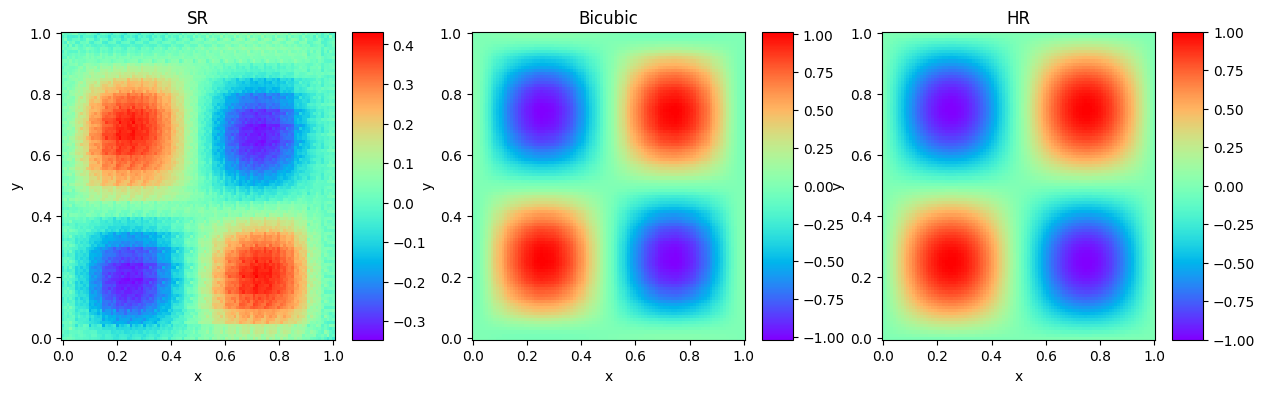

SR L2 Error: 0.42736522337209865
Bicubic L2 Error: 0.0035608024351483523


In [15]:
fig = plt.figure(figsize=(15,4))
# Around 200 epochs
'''plt.subplot(1,4,1)
plt.pcolormesh(x_low,y_low,w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')'''
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

### Test with others

In [18]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"test")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"test")

In [19]:
model = UpScale()
model.load_state_dict(torch.load('best_2D_model_generalise2.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy()
y = output.detach().numpy()

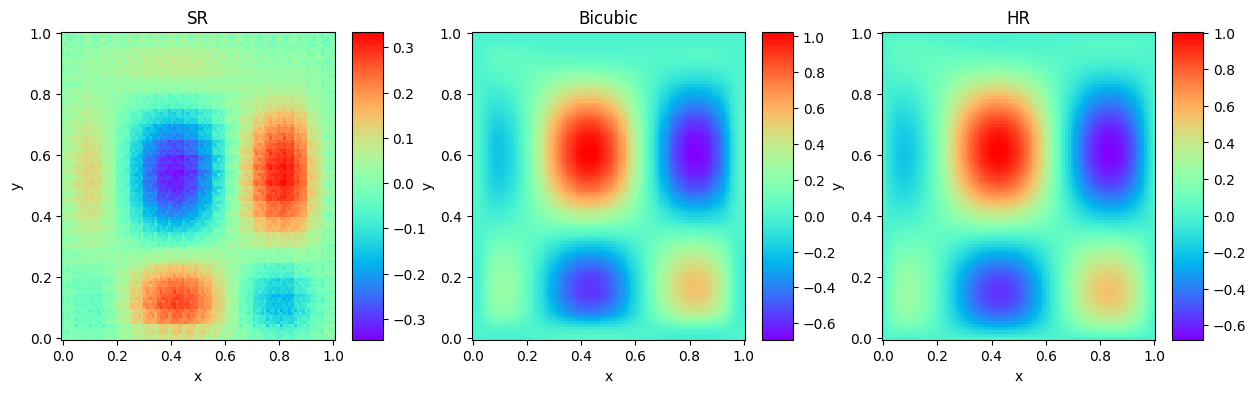

SR L2 Error: 0.1902120080185419
Bicubic L2 Error: 0.001858229275653429


In [20]:
fig = plt.figure(figsize=(15,4))
# Around 200 epochs
'''plt.subplot(1,4,1)
plt.pcolormesh(x_low,y_low,w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')'''
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)